# Syväoppimisen harjoitustyö

## Tehtävä 4-0

* Tekijä: Jere Soininen/AB6802

### Viesti työn arvioijille

Kiitos annetusta lisäajasta työn palautukseen. Tähän on kyllä vähän hankala palata parin viikon tauon jälkeen, mutta kyllä tämän kasaan saa...

Alkuperäisenä ajatuksena ja suuntana oli kasata yksi ohjaava markdown, ja antaa jokaiseen vaiheeseen yksi notebook, sillä itsestä tuntuu usein että todella pitkät notebookit ovat sekavia seurata ja navigoida.
Teen kuitenkin nyt muutoksen sillä työn tekemiseen tuli muutoksia sairastelun takia, ja kasaan yhden notebookin johon yhdistän ja dokumentoin aijemmin tekemiäni tiedostoja. Niitä onkin hyvin paljon (+10), joten tämä on varmasti teillekin nopeammin tarkastettavissa. En puske näitä kokeilutiedostoja. Tästä syystä selitykseni ja koodi saattaa olla välillä "löysästi" esitettyä.
  
### Aiheen valinta

Työn tarkoituksena on ennustaa jalkapallo pelaajien markkina-arvoja. Datana on käytetty [Kagglesta](https://www.kaggle.com/datasets/davidcariboo/player-scores/data) saatavaa dataa, joka on kerätty [transkermarkt](https://www.transfermarkt.com/)-sivulta.
Datan lähteenä käytetty sivusto on tunnettu sekä suosittu jalkapalloon liittässä statistiikassa sekä uutisissa.

Datasetti sisältää puhdasta, jäsenneltyä ja automaattisesti päivittyvää dataa Transfermarktista. Siinä on tietoa muun muassa:

* 60 000+ ottelusta useilta kausilta kaikissa suurissa kilpailuissa
* 400+ seurasta näistä kilpailuista
* 30 000+ pelaajasta näissä seuroissa
* 400 000+ historiallisesta pelaajamarkkina-arvotiedosta
* 1 200 000+ pelaajaesiintymisestä kaikista otteluista

Datasetti koostuu useista CSV-tiedostoista, jotka sisältävät tietoa kilpailuista, otteluista, seuroista, pelaajista ja pelaajaesiintymisistä. Jokaisessa tiedostossa on kohteen attribuutit ja ID:t, joiden avulla tiedostoja voi yhdistää toisiinsa. Datasetti päivittyy automaattisesti kerran viikossa. Työssä käytetään dataa joka on ladattu 8.11.2024.

Valitsin tämän aiheen sillä jalkapallo sekä siihen liittyvä data kiinnostavat minua kovasti. Jalkapallossa dataa käytetään kokoajan enemmän päätöstenteossa mukana ja se on näkyvässä osassa nykypäivänä.

Teknisesti tavoitteena on tehdä regressiomalli joka pystyisi ennustamaan pelaajien markkina-arvoja. Alustavana tavoitteena pidän 10% tarkkuuta keskiarvon ympäriltä.

## Tehtävä 4-1

### Datan esikäsittely ja tarkastelu

Tein aluksi yleistä tarkastelu eri CSV-tiedostoista. Katselin kolumneja ja niihin liittyviä perustietoja kun arvioin, miten alan parsimaan dataa haluttuun muotoon. Alla viimeisimpiä snippejä siistityssä muodossa kyseisestä tiedostosta.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Ladataan kilpailu- ja pelaajadatat
competitions_df = pd.read_csv('data/competitions.csv')
players_df = pd.read_csv('data/players.csv')

# 1. Pelaajamäärät liigoissa
player_counts = players_df['current_club_domestic_competition_id'].value_counts()
player_counts_df = player_counts.reset_index()
player_counts_df.columns = ['competition_id', 'player_count']

# Yhdistetään kilpailudataan
top_leagues = pd.merge(
    player_counts_df,
    competitions_df,
    on='competition_id',
    how='left'
)

# Näytetään top 10 liigaa pelaajamäärien mukaan
print("\nTop 10 liigaa pelaajamäärien mukaan:")
print(top_leagues[['name', 'player_count']].sort_values(by='player_count', ascending=False).head(10))

# Pääsarjat
major_leagues = competitions_df[competitions_df['is_major_national_league'] == True]
print("\nLiigat, joissa is_major_national_league == True:")
print(major_leagues[['name', 'country_name', 'is_major_national_league']])

# Top 50 kansallisuutta pelaajamääriuen mukaan
country_counts = players_df['country_of_citizenship'].value_counts()
print("\nTop 30 kansallisuutta pelaajamäärien mukaan:")
print(country_counts.head(50))
print(f"Top 30 kansallisuutta yhteensä: {country_counts.head(30).sum()} pelaajaa")

# Pelipaikkojen jakauma
position_counts = players_df['position'].value_counts()
print("\nPelipaikkojen jakauma:")
print(position_counts)

# Puuttuvat arvot
print("\nPuuttuvat arvot per sarake:")
print(players_df.isnull().sum())



Top 10 liigaa pelaajamäärien mukaan:
                 name  player_count
0           super-lig          3204
1             serie-a          3156
2  liga-portugal-bwin          2636
3      super-league-1          2596
4             ligue-1          2250
5              laliga          2213
6          eredivisie          2212
7      premier-league          2186
8  jupiler-pro-league          2180
9        premier-liga          2177

Liigat, joissa is_major_national_league == True:
              name country_name  is_major_national_league
9           laliga        Spain                      True
10         ligue-1       France                      True
11         serie-a        Italy                      True
16  premier-league      England                      True
33      bundesliga      Germany                      True

Top 30 kansallisuutta pelaajamäärien mukaan:
country_of_citizenship
Spain                 1955
Italy                 1887
France                1754
Brazil            

Yritin ottaa loogisen kuuloisia ominaisuuksia eri tiedostoista käyttöön ja yhdistää ne yhdeksi datasetiksi, mutta data oli huonoa.
Esimerkiksi puuttuvia tietoja oli aivan liikaa.

Olin aluksi valitsemassa top5 sarjoja jotta saisin dataa yhdenmukaista, mutta päädyin valitsemaan sittenkin aikarajatusti pelaajia. Tämä siksi, että on mielenkiintoista nähdä alempien sarjatasojen ennustuksia, vaikkakin se varmasti tekee datasta vaikempaa mallinnukselle. Toinen syy aikarajaukselle on se, että pelaajien markkina-arvoissa on tapahtunut suuria muutoksia ja keskiarvot ovat liikkuneet huomattavati ylöspäin pelkästään viime vuosikymmenen aikana.

(20330, 16)
player_id                               0
last_name                               0
name                                    0
last_season                             0
current_club_id                         0
player_code                             0
country_of_citizenship                  0
date_of_birth                           0
sub_position                            0
position                                0
foot                                    0
height_in_cm                            0
current_club_domestic_competition_id    0
current_club_name                       0
market_value_in_eur                     0
highest_market_value_in_eur             0
dtype: int64

Yhteenveto numeerisista sarakkeista:
          player_id   last_season  current_club_id  height_in_cm  \
count  2.033000e+04  20330.000000     20330.000000  20330.000000   
mean   4.169674e+05   2021.801033      5343.988982    182.438957   
std    2.696412e+05      2.091283     13107.865186      6.958

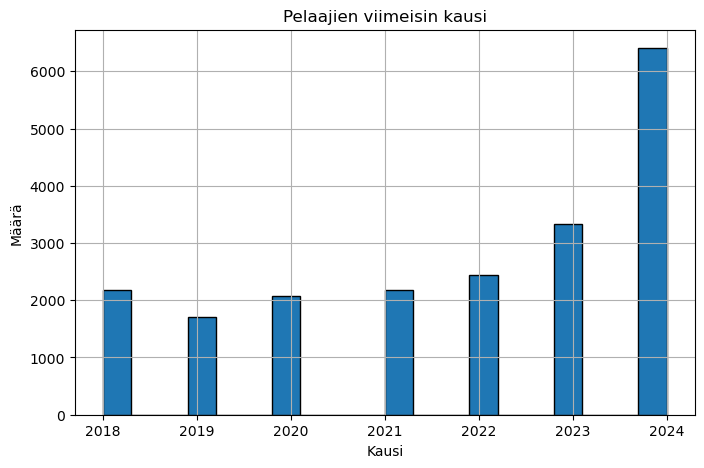

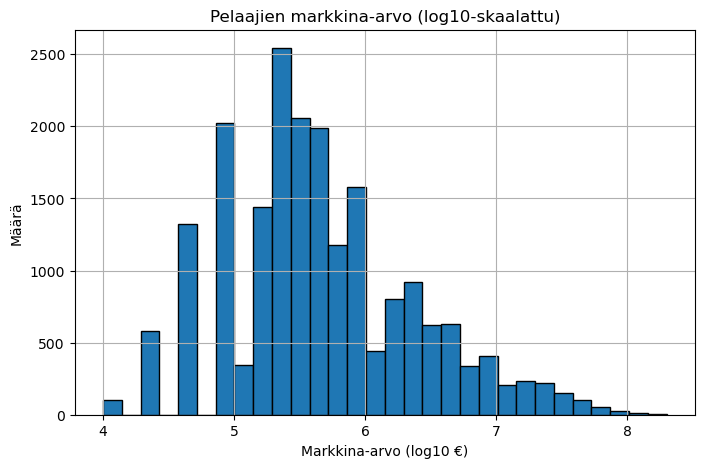

In [2]:
df = pd.read_csv('data/players.csv')

filtered_df = df[df['last_season'] >= 2018]

# Poistetaan sarakkeet joissa on paljon puuttuvia
columns_to_drop = [
    'first_name', 'city_of_birth', 'contract_expiration_date', 'agent_name', 
    'image_url', 'url', 'country_of_birth'
]
df = filtered_df.drop(columns=[col for col in columns_to_drop if col in filtered_df.columns])

# Täytetään puuttuvat arvot unknowilla tässä sarakkeessa
if 'country_of_citizenship' in df.columns:
    df['country_of_citizenship'] = df['country_of_citizenship'].fillna('Unknown')

# Poistetaan rivit rabkasti rivit joissa on puuttuvia arvoja halutuista sarakkeista
essential_columns = ['market_value_in_eur', 'highest_market_value_in_eur', 'date_of_birth', 'sub_position']
df = df.dropna(subset=essential_columns)

# Täytetään puuttuvat arvot yleisimmillä arvoilla halutuissa sarakkeissa
if 'foot' in df.columns:
    df['foot'] = df['foot'].fillna(df['foot'].mode()[0])
if 'height_in_cm' in df.columns:
    df['height_in_cm'] = df['height_in_cm'].fillna(df['height_in_cm'].mode()[0])

# yhteenveto tämän hetkisestä tilanteesta players tiedoston osalta
print(df.shape)
print(df.isnull().sum())
print("\nYhteenveto numeerisista sarakkeista:")
print(df.describe())

# Piirretään kuvaajia
# Histogrammi pelaajien korkeuksista
if 'last_season' in df.columns:
    plt.figure(figsize=(8, 5))
    df['last_season'].hist(bins=20, edgecolor='black')
    plt.title('Pelaajien viimeisin kausi')
    plt.xlabel('Kausi')
    plt.ylabel('Määrä')
    plt.show()

# Histogrammi pelaajien markkina-arvoista ja tähän oli pakko tehdä jonkinlainen sklaaus jotta
# kuvaaja oli luettavissa ja antoi mitään arvoa
if 'market_value_in_eur' in df.columns:
    plt.figure(figsize=(8, 5))
    # Suodatetaan nollat ja negatiiviset arvot, koska log ei toimi niille
    market_values = df['market_value_in_eur'][df['market_value_in_eur'] > 0]
    log_market_values = market_values.apply(lambda x: np.log10(x))
    log_market_values.hist(bins=30, edgecolor='black')
    plt.title('Pelaajien markkina-arvo (log10-skaalattu)')
    plt.xlabel('Markkina-arvo (log10 €)')
    plt.ylabel('Määrä')
    plt.show()

# Tallennetaan muokattu data tarvittaessa tiedostoon
# df.to_csv('data/2018_players_filtered.csv', index=False)


Tässä vaiheessa pelaajia on noin 20 000, mutta data tulee vielä laajenemaan reilusti kun pelaajat yhdistetään apperaces tiedostoon ja saadaan pelaajien pelidata käsittelyyyn mukaan. Seuraavissa stepeissa olen arvioinut eri tiedostoja ja mitä niistä haluan ottaa mukaan loppuliseen dataan. Tässä tavoitteena on ollut yhdistää pelaaja tietoja player_id:n mukaan.

In [3]:
# Ladataan nyt käsittelyyn halutut tiedostot
player_valuations = pd.read_csv('data/player_valuations.csv')
appearances = pd.read_csv('data/filtered_apps.csv')
players = pd.read_csv('data/2018_players_filtered.csv')
transfers = pd.read_csv('data/transfers.csv')

# Suodatetaan jokaisesta tiedostosta vain tarpeelliset sarakkeet
player_valuations = player_valuations[['player_id', 'market_value_in_eur', 'current_club_id', 'date', 'player_club_domestic_competition_id']]
appearances = appearances[['player_id', 'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played']]
players = players[['player_id', 'country_of_citizenship', 'date_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm', 'market_value_in_eur']]
transfers = transfers[['player_id', 'transfer_date', 'transfer_season', 'from_club_id', 'to_club_id', 'transfer_fee', 'market_value_in_eur']]


# Tiivistelmät dataseteistä joita halutaan mukaan
datasets = {
    "Player Valuations": player_valuations,
    "Appearances": appearances,
    "Players": players,
    "Transfers": transfers
}

for name, df in datasets.items():
    print(f"\n--- {name} ---")
    print(f"Rivit ja sarakkeet: {df.shape}")
    print("Puuttuvat arvot per sarake:")
    print(df.isnull().sum())
    print("Esimerkkirivit:")
    print(df.head(3))
    print("Numeeristen arvojen yhteenveto:")
    print(df.describe())



--- Player Valuations ---
Rivit ja sarakkeet: (487925, 5)
Puuttuvat arvot per sarake:
player_id                              0
market_value_in_eur                    0
current_club_id                        0
date                                   0
player_club_domestic_competition_id    0
dtype: int64
Esimerkkirivit:
   player_id  market_value_in_eur  current_club_id        date  \
0     405973               150000             3057  2000-01-20   
1     342216               100000             1241  2001-07-20   
2       3132               400000              126  2003-12-09   

  player_club_domestic_competition_id  
0                                 BE1  
1                                 SC1  
2                                 TR1  
Numeeristen arvojen yhteenveto:
          player_id  market_value_in_eur  current_club_id
count  4.879250e+05         4.879250e+05    487925.000000
mean   2.192169e+05         2.403025e+06      4404.586176
std    2.016662e+05         6.810939e+06     108

Yhdistetään neljä eri tiedostoa yhdeksi taulukoksi, jossa on pelaajien markkina-arvot, esiintymistiedot, henkilökohtaiset ominaisuudet ja siirtotiedot. Tiedostojen yhdistämisessä käytetään sisäliitosta jotta saadaan pelaajat jotka esiintyvät kaikissa tiedoissa.

In [4]:
# Nyt aloitetaan datan yhdistely eri tiedostoista
main_df = player_valuations.merge(appearances, on="player_id", how="inner")
main_df = main_df.merge(players, on="player_id", how="inner")

# Yhdistetään transfers-tiedosto vasemman liitoksen avulla, koska siirrot eivät välttämättä ole saatavilla kaikille pelaajille
main_df = main_df.merge(transfers, on="player_id", how="left")

# Tarkistetaan ja puhdistetaan yhdistetty data
columns_to_keep = [
    'player_id', 'market_value_in_eur', 'current_club_id', 'yellow_cards', 'red_cards',
    'goals', 'assists', 'minutes_played', 'position', 'foot', 'height_in_cm', 
    'country_of_citizenship', 'transfer_fee', 'date_of_birth', 'date', 'transfer_date'
]

# Säilytetään vain tarvittavat sarakkeet
main_df = main_df[[col for col in columns_to_keep if col in main_df.columns]]

# Poistetaan rivit, joissa markkina-arvo puuttuu sillä tästä tulee ennustettava luokka
main_df = main_df.dropna(subset=['market_value_in_eur'])

# Täydennetään transfer free medianilla. Tätä vähän palloilin että mikä olisi paras tapa korvata mutta
# jos rivit poistaisi niin datasta katoisi melkein 20%
main_df['transfer_fee'].fillna(main_df['transfer_fee'].median(), inplace=True)

# Tulostetaan lopullinen df ja tarkistetaan puuttuvat arvot
print(main_df.isnull().sum())
print(main_df.shape)
main_df.sample(3)

print(main_df.dtypes)

player_id                 0
market_value_in_eur       0
current_club_id           0
yellow_cards              0
red_cards                 0
goals                     0
assists                   0
minutes_played            0
position                  0
foot                      0
height_in_cm              0
country_of_citizenship    0
transfer_fee              0
date_of_birth             0
date                      0
transfer_date             0
dtype: int64
(968235, 16)
player_id                   int64
market_value_in_eur       float64
current_club_id             int64
yellow_cards                int64
red_cards                   int64
goals                       int64
assists                     int64
minutes_played              int64
position                   object
foot                       object
height_in_cm              float64
country_of_citizenship     object
transfer_fee              float64
date_of_birth              object
date                       object
transfer_date   

C:\Users\Jere\AppData\Local\Temp\ipykernel_42684\4223155096.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_df['transfer_fee'].fillna(main_df['transfer_fee'].median(), inplace=True)


Huomataan että data vaatii vielä reilusti käsittelyä ainakin objectien muokkaamisessa.

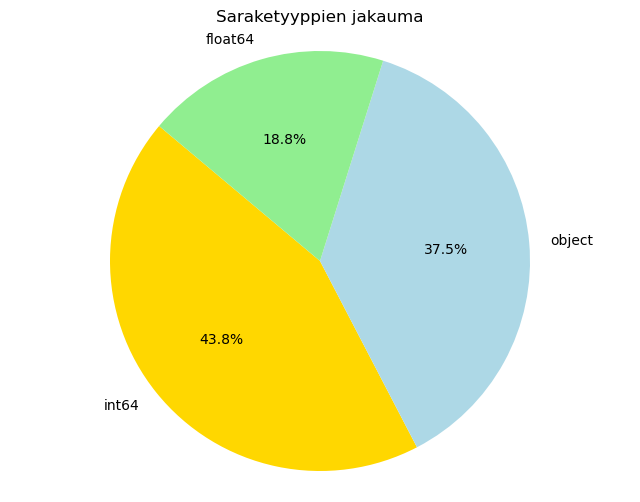

In [5]:
# Piiretään kuva datajakaumasta
dtypes_count = main_df.dtypes.value_counts()

labels = dtypes_count.index.astype(str)
sizes = dtypes_count.values
colors = ['gold', 'lightblue', 'lightgreen', 'coral']

# Kuvan piirto
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Saraketyyppien jakauma')
plt.axis('equal')
plt.show()

In [6]:
# date sarake katsottiin hyödyttömäksi (pelin päivämäärä)
main_df = main_df.drop(columns=['date'], errors='ignore')

# Datetime muutos
main_df['transfer_date'] = pd.to_datetime(main_df['transfer_date'], errors='coerce')
main_df['date_of_birth'] = pd.to_datetime(main_df['date_of_birth'], errors='coerce')

# Lasketaan ikä siirron tapahtuessa
main_df['age'] = (main_df['transfer_date'] - main_df['date_of_birth']).dt.days // 365

# Vältetään nollajakolasku
main_df['minutes_played'] = main_df['minutes_played'].replace(0, np.nan)

# lasketaan ga
main_df['GA_per_minute'] = (main_df['goals'] + main_df['assists']) / main_df['minutes_played']

# muutetaa mahdolliset Nan arvot nolliksi
main_df['GA_per_minute'] = main_df['GA_per_minute'].fillna(0)

# Tämä on vielä vähän harkinnan alla mikä on paras ratkaisu saamaan ilmaissiirrosta hyödyllinen sarake
#main_df['free_transfer'] = (main_df['transfer_fee'] == 0).astype(int)

# Tein ensin onehot enkooodauksella maat mutta noin 150 lisäsaraketta ei ollutkaan ihan haluttu tapa... Arvioin 
# että yleensä suosittu maa voi tuoda lisäarvoa sillä suurissa liigoissa voi olla sääntöjä joissa pitää olla
# liigan maasta kotoisin olevia (kansalaisuus tässä) tai omia kasvatteja
top_countries = main_df['country_of_citizenship'].value_counts().nlargest(50).index.tolist()

# 0/1 luokka jos on top country
main_df['is_top_country'] = main_df['country_of_citizenship'].apply(lambda x: 1 if x in top_countries else 0)

# Poistetaan object sarake
main_df = main_df.drop(columns=['country_of_citizenship'], errors='ignore')

# Onehot positionille ja jalalle
main_df = pd.get_dummies(main_df, columns=['position', 'foot'], drop_first=False)

bool_columns = ['position_Attack', 'position_Defender', 'position_Goalkeeper', 
                'position_Midfield', 'foot_both', 'foot_left', 'foot_right']

main_df[bool_columns] = main_df[bool_columns].astype(int)

# Määritellään numeeriset ominaisuudet, POISTETTUNA , 'free_transfer'!
numerical_features = [
    'height_in_cm', 'yellow_cards', 'red_cards', 'goals', 'assists',
    'minutes_played', 'GA_per_minute', 'transfer_fee', 'age', 'is_top_country'
]


Tässä kun yhdistelee tiedostoja ja yrittää parsia kaikkea kasaan niin huomaa virheitä ja muistaa ongelmia parin viikon takaa.
Tässä teen nyt rajun päätöksen ja poistan outlierit sillä muistan etä se oli iso ongelma mallinuksen kanssa.

EDIT: Tähän on vielä palattava, ja laskettava ylärajan arvoa, jotta data on tasapainoisempaa. Tällä hetkellä quantile(0.90) antaa

* Test Loss (MSE): 1.1255130767822266
* Test MAE: 0.8252246975898743

Joka tarkoittaa takaisin käännttynä noin 35% virhettä. Tässä kohtaa pitäisi palata sorvin ääreen datan esikäsittelyssä, mutta nyt kokeillaa tätä sillä aika on käymässä vähiin.

Data ilman outliereita: (715826, 22)
          player_id  market_value_in_eur  current_club_id   yellow_cards  \
count  7.158260e+05         7.158260e+05    715826.000000  715826.000000   
mean   2.821352e+05         1.097703e+06      7066.739694      16.813205   
min    4.391000e+03         1.000000e+04         3.000000       0.000000   
25%    1.354900e+05         2.500000e+05       405.000000       4.000000   
50%    2.504640e+05         5.000000e+05      1091.000000      11.000000   
75%    3.848020e+05         1.500000e+06      3385.000000      24.000000   
max    1.247360e+06         6.500000e+06    110302.000000     125.000000   
std    1.866760e+05         1.325770e+06     16506.452500      18.072108   

           red_cards          goals        assists  minutes_played  \
count  715826.000000  715826.000000  715826.000000   715826.000000   
mean        0.446426       7.063432       5.608049     8115.369299   
min         0.000000       0.000000       0.000000        1.000000  

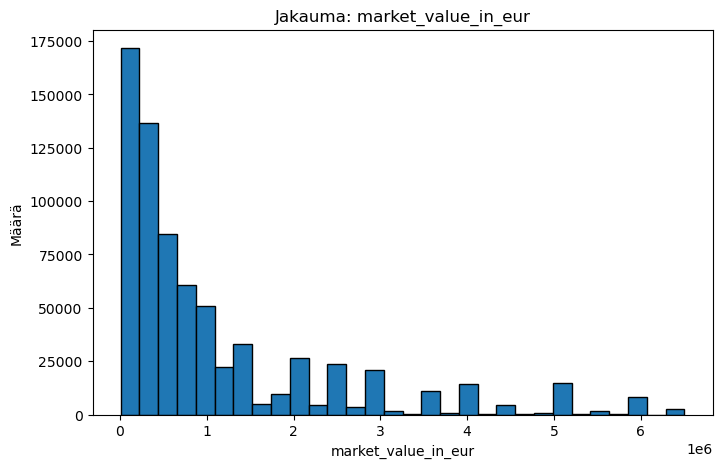

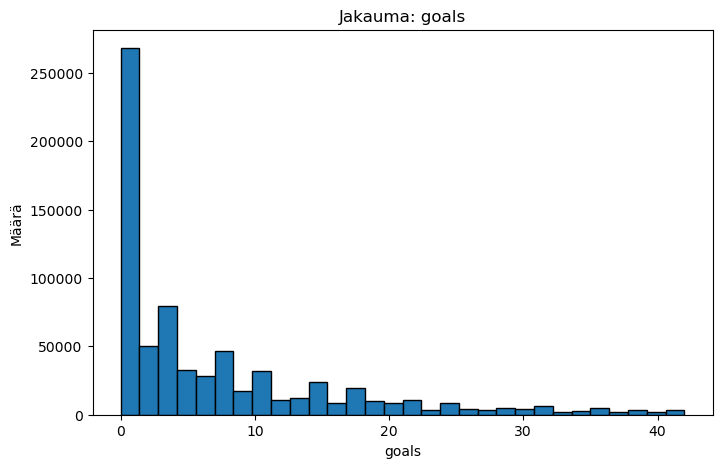

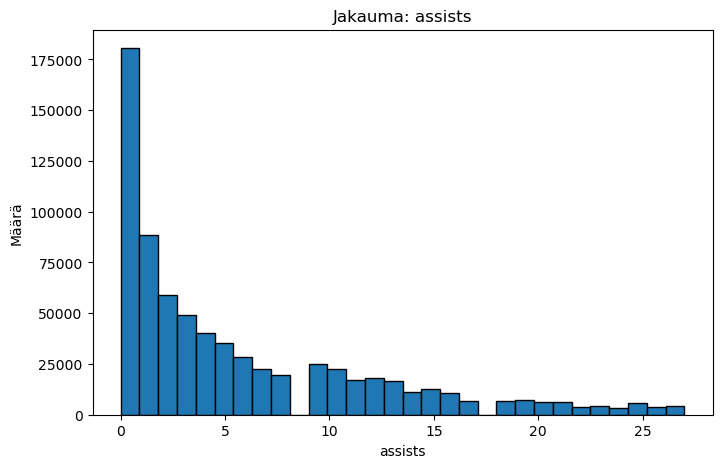

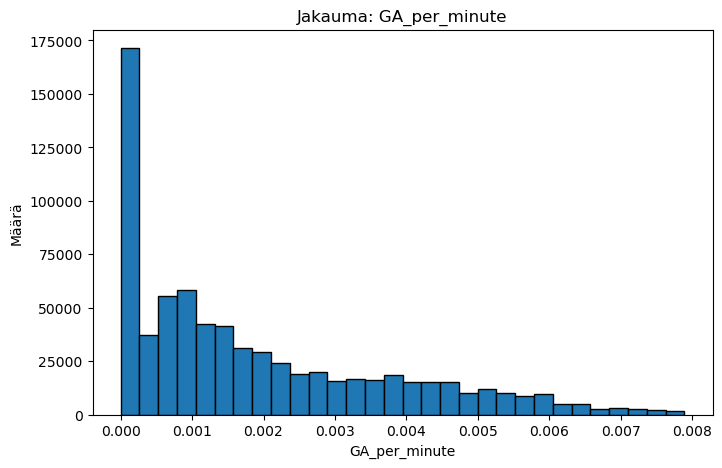

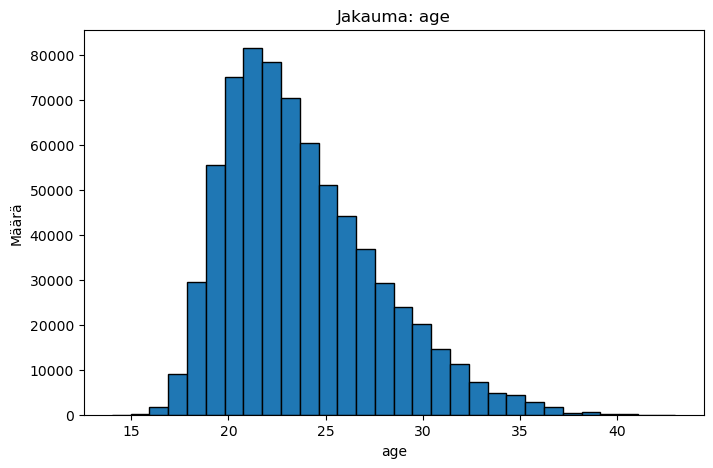

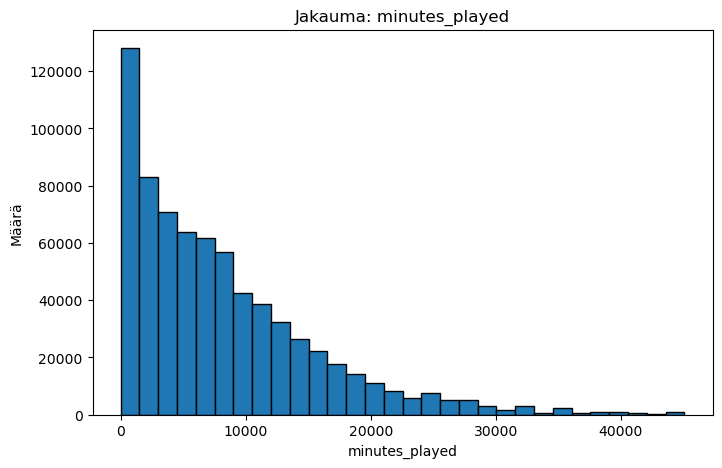

In [7]:
# IQR on tuttu muilta kursseilta ja todettu hyväksi, Tämä tiputti noin 10% datasta (uusi arvo 30%)
main_df_cleaned = main_df

def remove_outliers_iqr(data, columns):
    for column in columns:
        Q1 = data[column].quantile(0.10)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

# Sarakkeet joissa outlierit olivat häiritsevissä mittakaavoissa
columns_to_clean = [
    'market_value_in_eur', 'goals', 'assists', 
    'GA_per_minute'
]

main_df_cleaned = remove_outliers_iqr(main_df, columns_to_clean)

print(f"Data ilman outliereita: {main_df_cleaned.shape}")

# Katsotaan dataa muutoksein jälkeen ja olen tähän itseasiassa ihan tyytyväinen
summary_cleaned = main_df_cleaned.describe()
print(summary_cleaned)

#main_df_cleaned.to_csv('data/final_df.csv', index=False)


# Histogrammit tasoituksen jälkeen ja ennen skaalausta
columns_to_plot = ['market_value_in_eur', 'goals', 'assists', 'GA_per_minute', 'age', 'minutes_played']
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    plt.hist(main_df_cleaned[column], bins=30, edgecolor='black')
    plt.title(f'Jakauma: {column}')
    plt.xlabel(column)
    plt.ylabel('Määrä')
    plt.show()

In [8]:
# Skaalaus
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
main_df_cleaned[numerical_features] = scaler.fit_transform(main_df_cleaned[numerical_features])

# Tasoitetaan logaritmisella muunnoksella markkina-arvot
main_df_cleaned['market_value_in_eur'] = np.log1p(main_df_cleaned['market_value_in_eur'])

# Poistetaan tarpeettomat sarakkeet
main_df_cleaned = main_df_cleaned.drop(columns=['player_id', 'date_of_birth', 'transfer_date'], errors='ignore')

print(main_df_cleaned.describe())
print(main_df_cleaned.shape)

main_df_cleaned.to_csv('data/final_df.csv', index=False)

       market_value_in_eur  current_club_id  yellow_cards     red_cards  \
count        715826.000000    715826.000000  7.158260e+05  7.158260e+05   
mean             13.214091      7066.739694 -4.065769e-17 -4.208706e-17   
std               1.257527     16506.452500  1.000001e+00  1.000001e+00   
min               9.210440         3.000000 -9.303406e-01 -5.347056e-01   
25%              12.429220       405.000000 -7.090049e-01 -5.347056e-01   
50%              13.122365      1091.000000 -3.216674e-01 -5.347056e-01   
75%              14.220976      3385.000000  3.976736e-01  6.630431e-01   
max              15.687313    110302.000000  5.986400e+00  6.651786e+00   

              goals       assists  minutes_played  height_in_cm  transfer_fee  \
count  7.158260e+05  7.158260e+05    7.158260e+05  7.158260e+05  7.158260e+05   
mean  -1.651719e-17  8.433294e-17   -3.621075e-17  1.019619e-15 -4.621636e-17   
std    1.000001e+00  1.000001e+00    1.000001e+00  1.000001e+00  1.000001e+00   


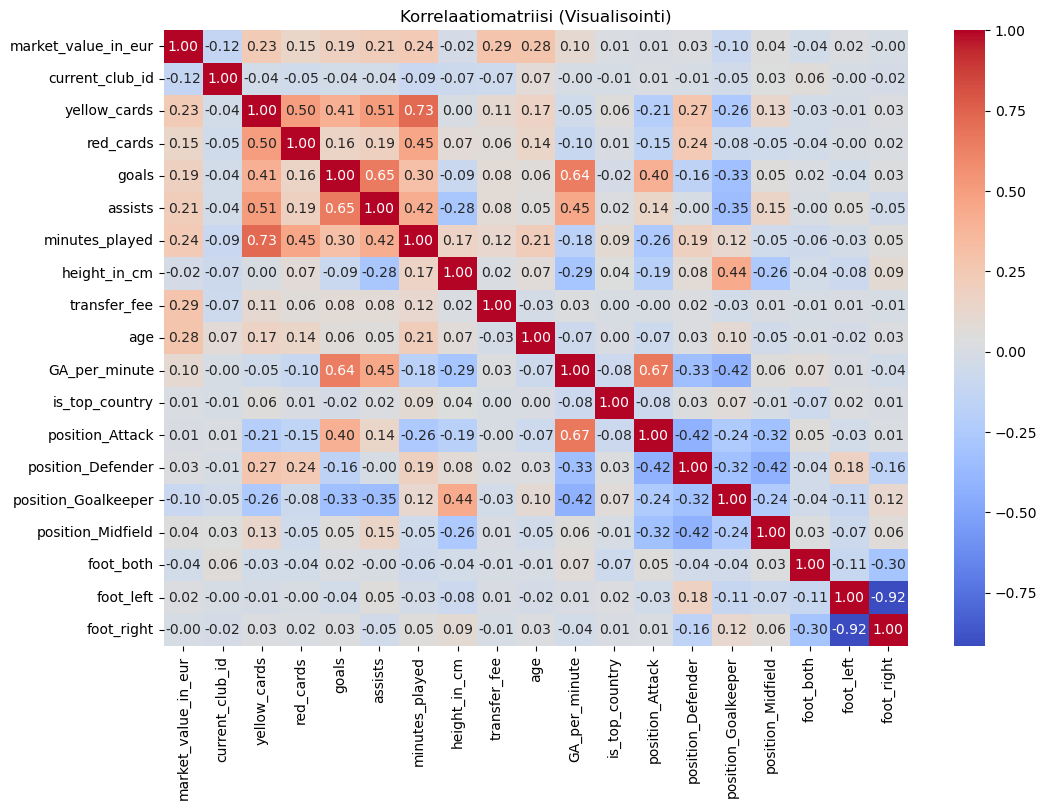

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = main_df_cleaned.corr()
#print(corr_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korrelaatiomatriisi (Visualisointi)')
plt.show()

### Välianalyysi

Datan käsittely alkaa olla valmista, mutta rehellisesti tämä on tuntunut monessa kohtaa aikamoiselta säädöltä ja jopa siltä että on lähtenyt lähestymään asioita väärin, mutta tässä sitä opitaan. Mielestäni datan yleinen katsaus ja rakenne on hyvää. Korrelaatiomatriisi on aika harmaata, mikä jännittää mallinukseen siirtyessä. Data oli oletettavasti aika monimutkaista ja tämä on varmaan tekijä tässä. Nyt ei kuitenkaan ole aikaa enään tätä hieroa, joten lähdetään tällä kokeilemaan mallinnusta ja katsotaan mitä saadaan aikaiseksi. Datan muoto (868907, 19) on mielestäni okei.

## Tehtävä 4-2

Aloitetaan mallinnus. Tavoitteena olisi tuottaa yksi syväoppimismalli ja yksi koneoppimismalli, jotta tuloksia voidaan vertailla ja tehdä päätelmiä.

In [10]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

df = pd.read_csv('data/final_df.csv')

# Tämä ei auttanut
"""
selected_features = [
    'market_value_in_eur', 'age', 'minutes_played', 'current_club_id', 
    'GA_per_minute', 'yellow_cards', 'goals', 'assists', 'red_cards'
]

df = df[selected_features]
"""

print(df.shape)
print(df.dtypes)

X = df.drop(columns=['market_value_in_eur'])
y = df['market_value_in_eur']

# Muunnetaan kaikki arvot liukuluvuiksi, jos tätä ei tee tulee virhettä
X = X.astype('float32')
y = y.astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(715826, 19)
market_value_in_eur    float64
current_club_id          int64
yellow_cards           float64
red_cards              float64
goals                  float64
assists                float64
minutes_played         float64
height_in_cm           float64
transfer_fee           float64
age                    float64
GA_per_minute          float64
is_top_country         float64
position_Attack          int64
position_Defender        int64
position_Goalkeeper      int64
position_Midfield        int64
foot_both                int64
foot_left                int64
foot_right               int64
dtype: object


In [11]:
# Määritellään malli
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Kaikenlaista parametrointia pienillä tuloksilla
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='huber_loss', metrics=['mae'])

# Dynaaminen lrs
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 0.001 * 0.9 ** epoch
)

# Koulutetaan malli
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# verbose nolla testien jälkeen
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stopping, lr_scheduler]
)

test_loss, test_mae = model.evaluate(X_test, y_test)

print(f'Test Loss (MSE): {test_loss}')
print(f'Test MAE: {test_mae}')

# Ennusteet testidatalla
predictions = model.predict(X_test)

4474/4474 [==============================] - 2s 445us/step - loss: 0.3774 - mae: 0.7339
Test Loss (MSE): 0.3773614764213562
Test MAE: 0.7338539958000183
4474/4474 [==============================] - 2s 371us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4864      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 3

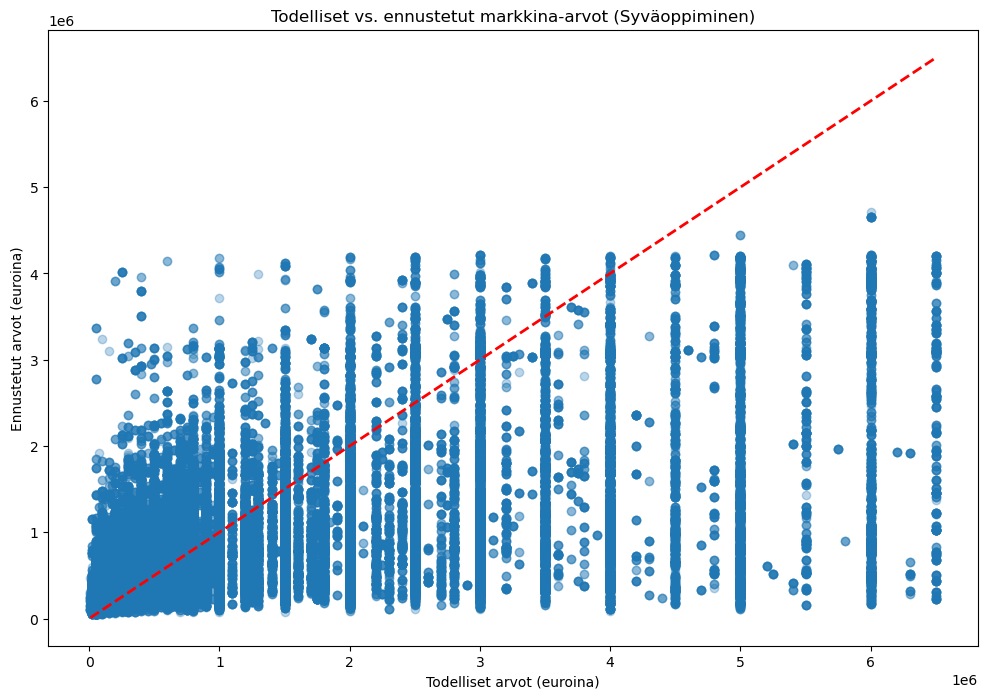

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

model.summary()

# Muunna ennusteet ja todelliset arvot takaisin alkuperäiselle asteikolle
actual_original_scale = np.expm1(y_test)
predicted_original_scale = np.expm1(predictions)

r2_original = r2_score(actual_original_scale, predicted_original_scale)

print(f"R^2 (original scale): {r2_original}")

# Virhe mittakaavassa ja tämä on noin 29%...
errors_original_scale = actual_original_scale - predicted_original_scale.flatten()

print(errors_original_scale.mean())

# Kuvaaja ennnusteuille arvoille suhteessa oikeisiin arvoihin
plt.figure(figsize=(12, 8))
plt.scatter(actual_original_scale, predicted_original_scale, alpha=0.3)
plt.plot([actual_original_scale.min(), actual_original_scale.max()], 
         [actual_original_scale.min(), actual_original_scale.max()], 'r--', lw=2)
plt.xlabel("Todelliset arvot (euroina)")
plt.ylabel("Ennustetut arvot (euroina)")
plt.title("Todelliset vs. ennustetut markkina-arvot (Syväoppiminen)")
plt.show()

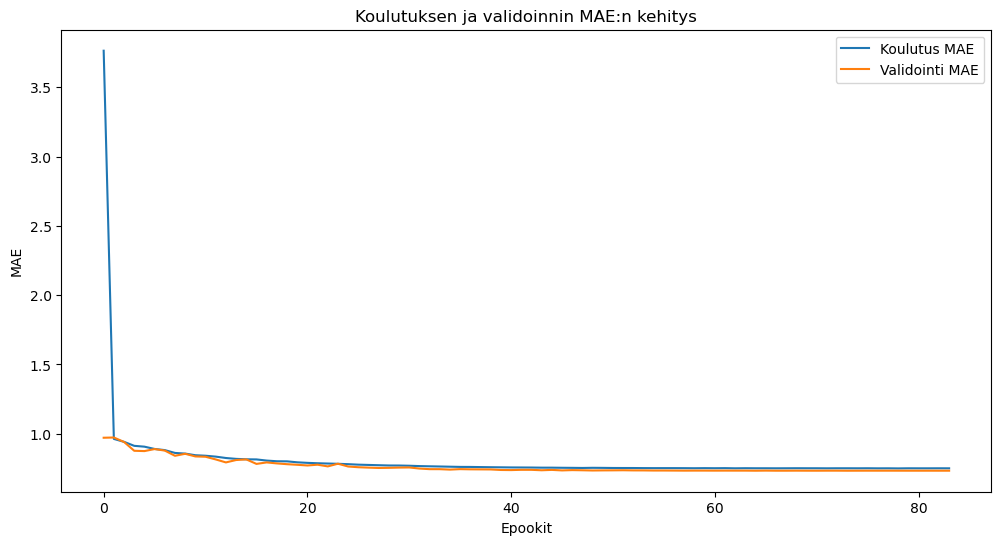

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Koulutus MAE')
plt.plot(history.history['val_mae'], label='Validointi MAE')
plt.xlabel('Epookit')
plt.ylabel('MAE')
plt.title('Koulutuksen ja validoinnin MAE:n kehitys')
plt.legend()
plt.show()


Random Forest - Test Loss (MSE): 0.01537873401595756
Random Forest - Test MAE: 0.037561830315825315
5552.068000050136
RF R^2 (original scale): 0.9874180753425095


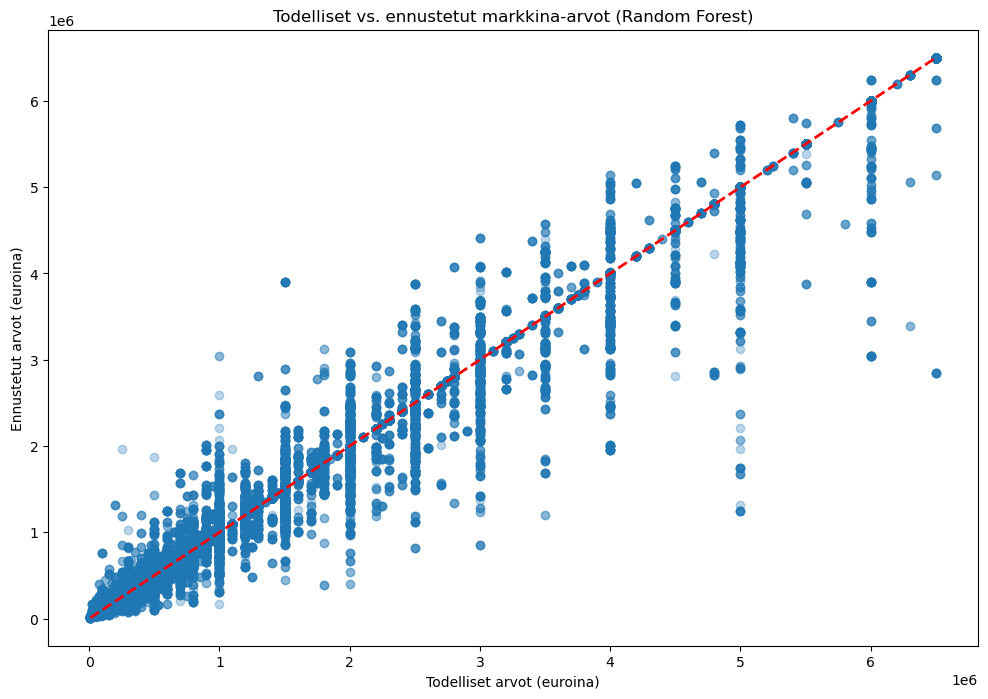

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv('data/final_df.csv')

X = df.drop(columns=['market_value_in_eur'])
y = df['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# mallin parametrit
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Koulutus
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

# mean squared error ja mean absolute error jotka ovat jo paljon parempi ja näkyvät myös kuvassa
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)

print(f'Random Forest - Test Loss (MSE): {rf_mse}')
print(f'Random Forest - Test MAE: {rf_mae}')

# Muunna takaisin alkuperäiselle asteikolle
y_test_original = np.expm1(y_test)  # Muunnetaan todelliset arvot
rf_predictions_original = np.expm1(rf_predictions)  # Muunnetaan ennusteet

# Virhe mittakaavassa ja tämä on noin 33%...
rf_errors_original_scale = y_test_original - rf_predictions_original.flatten()

print(rf_errors_original_scale.mean())

rf_r2_original = r2_score(y_test_original, rf_predictions_original)

print(f"RF R^2 (original scale): {rf_r2_original}")

# Todelliset vs. ennustetut alkuperäisellä asteikolla
plt.figure(figsize=(12, 8))
plt.scatter(y_test_original, rf_predictions_original, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel("Todelliset arvot (euroina)")
plt.ylabel("Ennustetut arvot (euroina)")
plt.title("Todelliset vs. ennustetut markkina-arvot (Random Forest)")
plt.show()


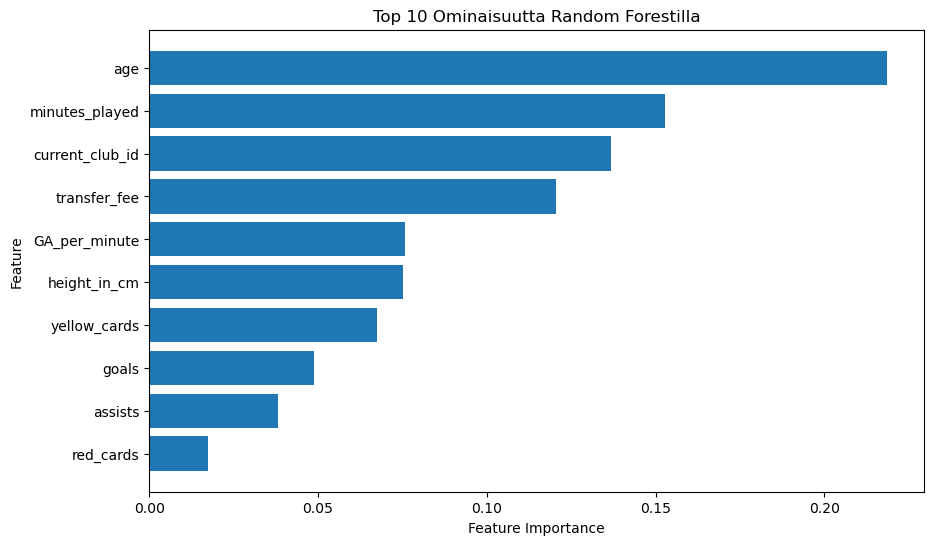

In [15]:
# Näitäkin kokeiltiin mutta se vain heikensi suorittamista mikä juuri viittaisi ainakin ominaisuuksien puutteeseen

feature_importances = rf_model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Ominaisuutta Random Forestilla')
plt.gca().invert_yaxis()
plt.show()


## Tehtävä 4-3 Tulosten analysointi

### Analysoi ja vertaile malleilla saamiasi oppimistuloksia

Tuloksia syväoppiminen:

* R^2 = 0.304
* MAE, original scale: 325 137€ (29%)
* Test Loss (MSE): 0.3755
* Test MAE: 0.7324

Tulosksia RF:

* RF R^2 (original scale): 0.9874180753425095
* MAE, original scale: 5552 € (0.5%)
* Random Forest - Test Loss (MSE): 0.0153
* Random Forest - Test MAE: 0.0375

Tässä nyt kyllä tuntuu olevan avattavaa... Mallini ei mielestäni suoriutunut hyvin, ja tuntui että olisi voinut tehdä tätä vielä tuntitolkulla, mutta johonkin vedettävä raja. En tosin tiedä oliko alkuperäinen 10% tavoite liian haastava nykyisellä osaamisella
ja ajankäytöllä. Jos olisi nyt vielä intoa niin olisi kiva kokeilla syväoppimisella luokka ongelmaa niin, että luokittelee pelaajat
esim. 3-5 ryhmään ja yrittäisi ennustaa näitä.


Mallin kuvaajassa huomasi kuinka moni pelaaja oli datassa markkina-arvoltaan tasamiljoonissa, joten tuli paljon palkkeja niiden
kohdille. Harmillisesti näissä palkeissa moni kallis pelaaja oli ennustettu lähelle nollaa... Olisi kiva jos osaisi avata enemmän
syitä näille asioille.

Virhearvot kertovat sitä mitä näämmekin, eli malli tekee suuria virheitä eikä data meinaa oikein maistua sille. Yritin karsia dataa
yhdessä kohtaa reilusti, mutta se heikensi tulosta. Datan valinnan suhteen on ollut itsellä aika epävarma olo, joten ehkä se nyt näkyy tässä. R^2 kertoo että malli osaa selittää noin 30% kohdearvojen vaihtelusta, kun arvot ovat taas alkuperäisessä mittakaavassa. Paljon kyllä testailin ja hieroin parametreja, mutta tulokset parhaimillaan pyörivät samoilla huudeilla.

RF suoriutuikin huomattavasti paremmin. R^2 mukaan se osasi selittää 92% kohdearvojen vaihtelusta ja suhteellinen virhe olisi ollut vain 0.5%. Kuvaa katsoessa nämä arvot ovat melkein uskomattomia... Ainut mikä voisi selittää on se, että aivan kuvaajan alakulmassa on saatu paljon oikein tai ainakin todella lähelle. Se on silti selvää, että tämä suoritui paremmin.

Kyselin GPT:eltä apuja jos se osaisi sanoittaa minulle mistä tämä johtui, ja sain tälläistä kuvaa omin sanoin:

Oliko minulla oikeasti liian vähän dataa? Kun pienensin IQR-rajoilla datan määrää, niin tulos parani. Tässä tosin todennäköistä on se, että outlierien poiston hyöty oli suurempi mitä datan pienemisen haitta. Sain vinkkiä että data olisi ollut liian yksinkertaista ja pientä syväoppimismallilla, mutta mielestäni yksinkertaisemmatkaan mallit eivät auttaneet tulostani. Jätän tähän tiedostoon parhaan suorituksen mitä olen saanut. Vaikka mielessäni data oli monimutkaista ja olisi voinut sopia hyvin syväoppimisella, näin se ei näköjään ollut.

Keskityin ehkä liikaa datan kokoon, enkä aidosti sen sisältöön.

Okei, tästä tulee taas sekavaa sekoilua, mutta:

Käsin katsomassa tehtäviä ja muistin model.summary() pätkän, joka näytti minulle että parametrimäärä oli 48k. Tätä olisi pitänyt hyödyntää jo aijemmin, mutta tämän antaa minulle hyvää palautetta kun sitä vertaa datani määrään. Parametri määrä on ilmeisesti kohtuullinen, vaikkakin pienempi kuin harjoituksissa. Rivejäkin löytyyy, mutta ominaisuudet jäivät todennäköisesti liian kapeiksi, ja mallin kapasitetti saatta olla liian suuri tämän takia ja malli ylikouluttuisi tai ainakin olisi liian pätevä tälle datalle?

Tekisi niin mieli vielä palata säätämään ja kokeilemaan, mutta nyt on pakko laittaa tätä kasaan.

Tehtävä oli mielenkiintoinen ja sitä jaksoi tehdä. Oli toki erilaista hypätä ensimmäistä kertaa omaan projektiin mitä teki ilman fiksumpien apuja tai pohjatöitä, mutta tulipahan opittua vaikkei se välttämättä hyvissä ja kiiltävissä tuloksissa näy. Minulla on vieläkin vähän kysymysmerkkinä, että menikö tämä täysin metsään vai oliko minulla esimerkiksi liian kunnianhimoiset tavoitteet. On vaan niin ärsytävää palauttaa työ mikä tuntuu virheelliseltä ja mistä ei saa täysin tolkkua...

Positiivista on se että yksi omista näkemyksistä oppimisen suhteen täyttyi: Jos tekisin tämän uudestaan, tästä tulisi varmasti parempi.
